In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import pickle
import random

import shap
from pdpbox import pdp
import matplotlib.pyplot as plt
import japanize_matplotlib

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_df = pd.read_csv('./output/中間データ/train_preprocessed.csv')
train_df.head()

,new_y,popular,fun,week,unpopular,temperature,day,kcal,temp,curry,...,y_5lag,y_rolling_mean_3,y_rolling_max_3,y_rolling_min_3,y_rolling_mean_7,y_rolling_max_7,y_rolling_min_7,y_rolling_mean_14,y_rolling_max_14,y_rolling_min_14
0,0.321153,1,0,-0.932992,0,-1.095479,-0.808939,1.048743,0.642341,0,...,1.506434,1.516070,1.236957,0.741170,2.107463,1.697366,1.1992,2.373105,2.220246,1.481382
1,-1.848836,1,0,-0.908046,1,-1.763701,-0.695212,1.217961,-1.080469,0,...,1.470161,2.253901,1.236957,3.121881,1.955637,0.959839,1.1992,2.285349,2.220246,1.481382
2,0.410879,0,0,-0.073296,0,-1.683054,-0.240304,-0.948028,-0.872544,0,...,-0.017009,1.591359,1.164996,1.088357,1.631283,0.829687,1.1992,2.049086,2.220246,1.481382
3,0.718736,1,0,0.220722,0,-2.017165,-0.126577,1.556397,-1.733949,0,...,1.832886,1.606417,1.164996,1.088357,1.679591,0.829687,1.1992,2.116590,2.220246,1.481382
4,-0.661561,0,0,-0.932992,1,-1.544801,-0.012851,0.371872,-0.516100,0,...,1.724068,1.681706,1.344899,1.088357,1.769306,0.959839,1.1992,2.194219,2.220246,1.481382


In [3]:
X_train = train_df.drop(columns=['new_y'])
y_train = train_df['new_y']

In [4]:
# 再現性確保のための固定シード
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)

# Optunaのシードも固定
sampler = optuna.samplers.TPESampler(seed=SEED)

# LightGBMにも同様に
base_params = {
    'objective': 'regression_l1',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'random_state': SEED,
    'verbosity': -1
}

In [5]:
tscv = TimeSeriesSplit(n_splits=5)

#### ハイパーパラメータチューニング

In [6]:
# STEP 1: 大きめのlearning_rateで n_estimators を最適化
def find_best_n_estimators(params, X, y, tscv):
    best_n = 100
    best_score = float('inf')

    for n in range(50, 1001, 50):
        scores = []
        for train_idx, val_idx in tscv.split(X):
            # Dataset の作成
            lgb_train = lgb.Dataset(X.iloc[train_idx], label=y.iloc[train_idx])
            lgb_val = lgb.Dataset(X.iloc[val_idx], label=y.iloc[val_idx], reference=lgb_train)

            # 学習
            model = lgb.train(
                params,
                train_set=lgb_train,
                num_boost_round=n,  # ← 試行中の n_estimators
                valid_sets=[lgb_val]
            )

            # 予測
            pred = model.predict(X.iloc[val_idx])
            score = np.sqrt(mean_squared_error(y.iloc[val_idx], pred))
            scores.append(score)

        avg_score = np.mean(scores)
        if avg_score < best_score:
            best_score = avg_score
            best_n = n

    return best_n

best_n1 = find_best_n_estimators(base_params, X_train, y_train, tscv)
base_params['num_boost_round'] = best_n1

In [7]:
# STEP 2: 木のパラメータをチューニング
def objective_tree(trial):
    params = {
        **base_params,
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    }

    scores = []
    for train_idx, val_idx in tscv.split(X_train):
        lgb_train = lgb.Dataset(X_train.iloc[train_idx], label=y_train.iloc[train_idx])
        lgb_val = lgb.Dataset(X_train.iloc[val_idx], label=y_train.iloc[val_idx], reference=lgb_train)

        model = lgb.train(
            params,
            train_set=lgb_train,
            valid_sets=[lgb_val],
            num_boost_round=base_params.get('num_boost_round', 100)
        )

        pred = model.predict(X_train.iloc[val_idx])
        score = np.sqrt(mean_squared_error(y_train.iloc[val_idx], pred))
        scores.append(score)

    return np.mean(scores)

study_tree = optuna.create_study(direction='minimize', sampler=sampler)
study_tree.optimize(objective_tree, n_trials=50)

# 最良パラメータで base_params を更新
base_params.update(study_tree.best_params)

[I 2025-05-19 01:11:01,600] A new study created in memory with name: no-name-05e40771-a5b8-4a15-b862-91c95a02c60f
[I 2025-05-19 01:11:02,593] Trial 0 finished with value: 1.0799218832881372 and parameters: {'max_depth': 5, 'num_leaves': 194, 'min_child_samples': 47, 'subsample': 0.8926792918568847, 'colsample_bytree': 0.8899879040594018}. Best is trial 0 with value: 1.0799218832881372.
[I 2025-05-19 01:11:03,108] Trial 1 finished with value: 1.0287888679078718 and parameters: {'max_depth': 6, 'num_leaves': 97, 'min_child_samples': 81, 'subsample': 0.9790696768418525, 'colsample_bytree': 0.9379663173710473}. Best is trial 1 with value: 1.0287888679078718.
[I 2025-05-19 01:11:03,800] Trial 2 finished with value: 1.056580231756692 and parameters: {'max_depth': 7, 'num_leaves': 160, 'min_child_samples': 70, 'subsample': 0.85635101349145, 'colsample_bytree': 0.6851253773951975}. Best is trial 1 with value: 1.0287888679078718.
[I 2025-05-19 01:11:10,974] Trial 3 finished with value: 0.770596

In [8]:
# STEP 3: 正則化パラメータのチューニング
def objective_reg(trial):
    params = {
        **base_params,
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0),
    }

    scores = []
    for train_idx, val_idx in tscv.split(X_train):
        lgb_train = lgb.Dataset(X_train.iloc[train_idx], label=y_train.iloc[train_idx])
        lgb_val = lgb.Dataset(X_train.iloc[val_idx], label=y_train.iloc[val_idx], reference=lgb_train)

        model = lgb.train(
            params,
            train_set=lgb_train,
            valid_sets=[lgb_val],
            num_boost_round=base_params.get('num_boost_round', 100)
        )

        pred = model.predict(X_train.iloc[val_idx])
        score = np.sqrt(mean_squared_error(y_train.iloc[val_idx], pred))
        scores.append(score)

    return np.mean(scores)

study_reg = optuna.create_study(direction='minimize', sampler=sampler)
study_reg.optimize(objective_reg, n_trials=50)

# 最良の正則化パラメータで base_params を更新
base_params.update(study_reg.best_params)

[I 2025-05-19 01:13:27,566] A new study created in memory with name: no-name-c5d8c635-a290-44a2-8ab0-94b180c3a63e
[I 2025-05-19 01:13:30,768] Trial 0 finished with value: 0.7760919679751316 and parameters: {'reg_alpha': 0.5594715878720191, 'reg_lambda': 3.035968531092423}. Best is trial 0 with value: 0.7760919679751316.
[I 2025-05-19 01:13:33,944] Trial 1 finished with value: 0.7773493808168381 and parameters: {'reg_alpha': 2.829723215252657, 'reg_lambda': 0.03382030995001395}. Best is trial 0 with value: 0.7760919679751316.
[I 2025-05-19 01:13:37,070] Trial 2 finished with value: 0.7810009341586219 and parameters: {'reg_alpha': 3.087208544021485, 'reg_lambda': 4.560614432165772}. Best is trial 0 with value: 0.7760919679751316.
[I 2025-05-19 01:13:40,251] Trial 3 finished with value: 0.7727962422451954 and parameters: {'reg_alpha': 3.952620665285167, 'reg_lambda': 4.960407330941807}. Best is trial 3 with value: 0.7727962422451954.
[I 2025-05-19 01:13:43,028] Trial 4 finished with value

In [9]:
# STEP 4: learning_rateを下げてn_estimators再最適化
base_params['learning_rate'] = 0.01
best_n2 = find_best_n_estimators(base_params, X_train, y_train, tscv)
base_params['n_estimators'] = best_n2

#### 全データで学習

In [10]:
# LightGBM Dataset の作成
lgb_train = lgb.Dataset(X_train, label=y_train)

callbacks = [
    lgb.log_evaluation(period=50)
]

# モデルの再学習（最終学習）
final_model = lgb.train(
    base_params,
    train_set=lgb_train,
    callbacks=callbacks,
)

# トレーニングデータで予測
y_train_pred = final_model.predict(X_train)

# RMSEを計算
final_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

print(f"LightGBMのトレーニングRMSE: {final_rmse:.4f}")

LightGBMのトレーニングRMSE: 0.3238


In [11]:
# 保存用のディクショナリにまとめる
model_package = {
    'model': final_model,
    'feature_name': X_train.columns.tolist()
}

# 保存
with open('./output/モデル/lgb_model.pkl', 'wb') as f:
    pickle.dump(model_package, f)

#### 特徴量重要度

In [12]:
shap_sample = X_train.sample(n=100, random_state=1234)

In [13]:
# shap値の取得
def get_shap_value(model, shap_sample, model_type, masker_data=None):
    if model_type == 'tree':
        explainer =shap.TreeExplainer(model, feature_perturbation='tree_path_dependent', model_output='raw')
    shap_values = explainer.shap_values(shap_sample)
    shap_values = np.array(shap_values, dtype=np.float64)

    return shap_values

# 重要特徴量の計算
def compute_shap_importance(shap_values, shap_sample):
    if isinstance(shap_values, list):
        shap_array = np.abs(shap_values[0])
    elif hasattr(shap_values, 'values'):
        shap_array = np.abs(shap_values.values)
    else:
        shap_array = np.abs(shap_values)
    
    shap_importance = pd.DataFrame({
        '特徴量': shap_sample.columns,
        '特徴量の重要度': shap_array.mean(axis=0)
    }).sort_values(by='特徴量の重要度', ascending=False)

    max_importance = shap_importance['特徴量の重要度'].max()
    shap_importance['特徴量の相対的重要度'] = shap_importance['特徴量の重要度'] / max_importance

    display(shap_importance.head(100))

    return shap_importance

In [14]:
shap_values = get_shap_value(final_model, shap_sample, 'tree', masker_data=None)
shap_importance = compute_shap_importance(shap_values, shap_sample)

,特徴量,特徴量の重要度,特徴量の相対的重要度
0,popular,0.268570,1.000000
3,unpopular,0.167632,0.624164
2,week,0.151400,0.563727
1,fun,0.124393,0.463167
8,curry,0.063715,0.237239
4,temperature,0.046273,0.172295
5,day,0.034450,0.128272
6,kcal,0.034116,0.127030
7,temp,0.034069,0.126854
20,y_5lag,0.024643,0.091758


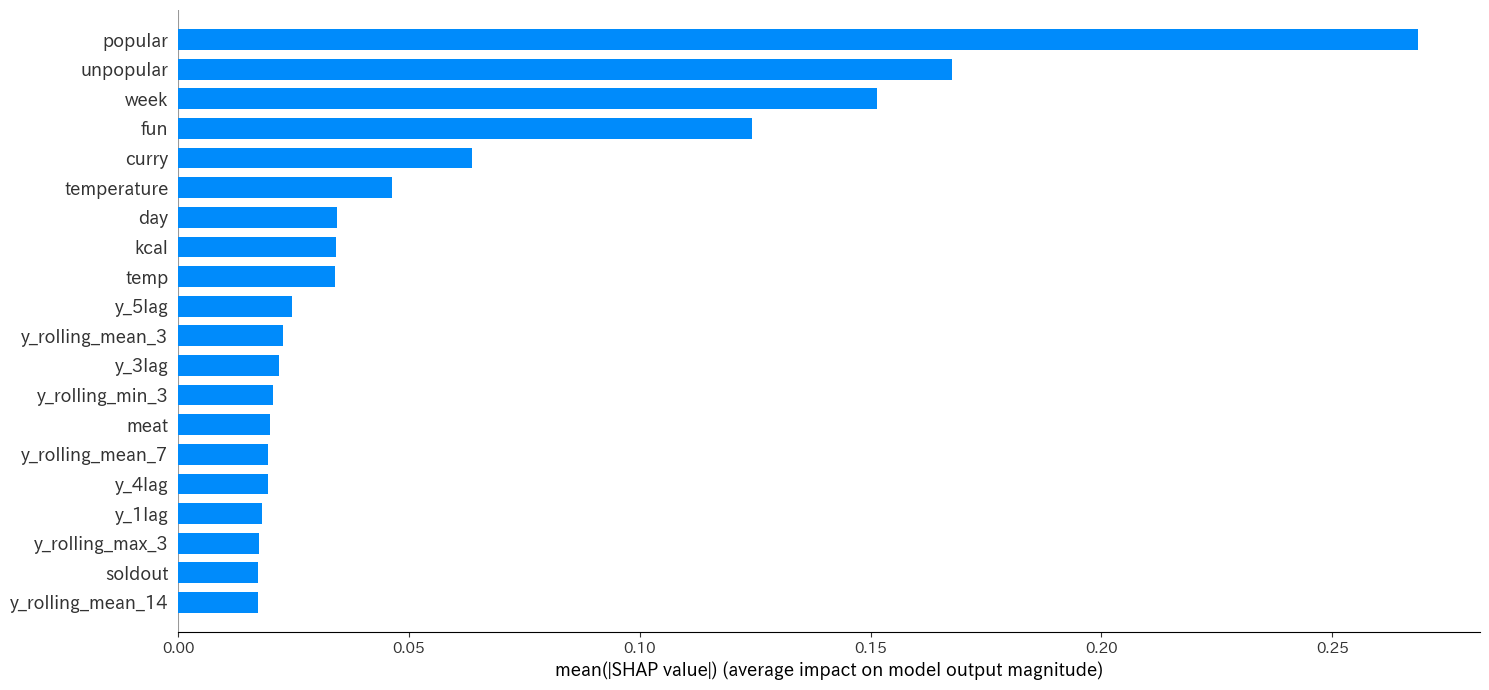

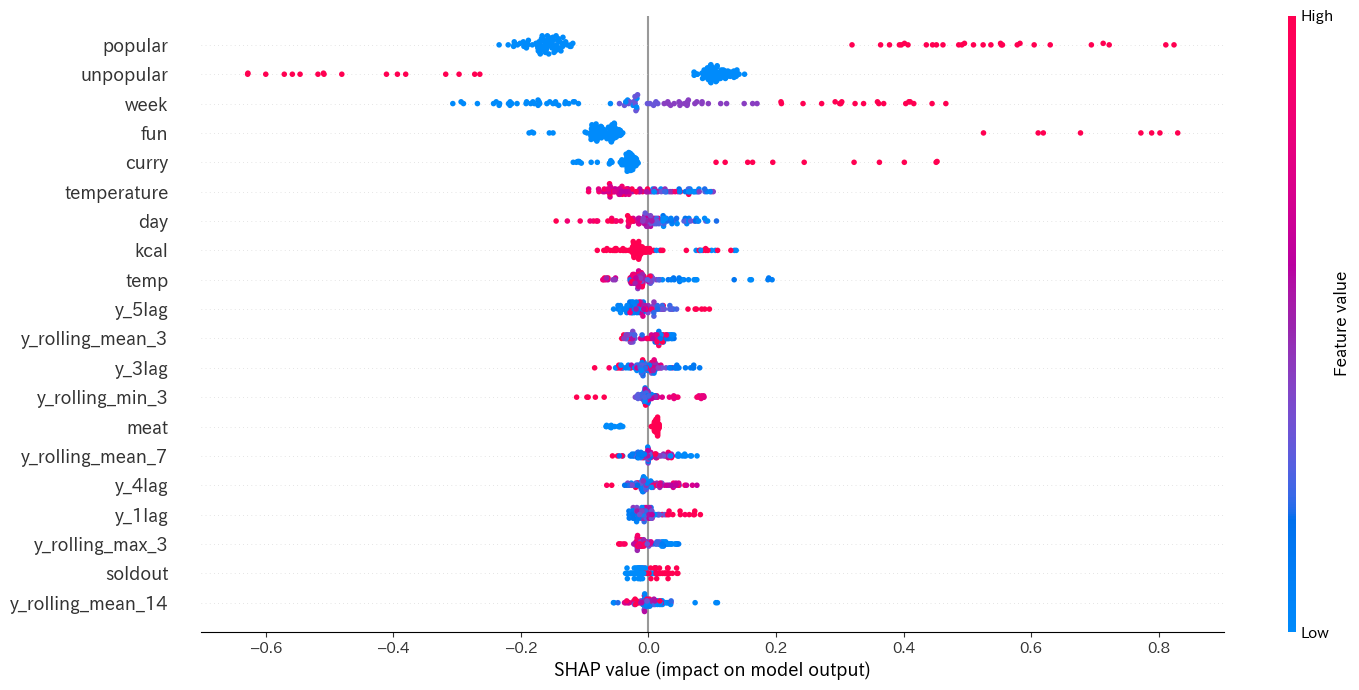

In [15]:
# 特徴量重要度の可視化
shap.summary_plot(shap_values, shap_sample, plot_type='bar', plot_size=(15, 7))
shap.summary_plot(shap_values, shap_sample, plot_size=(15, 7))

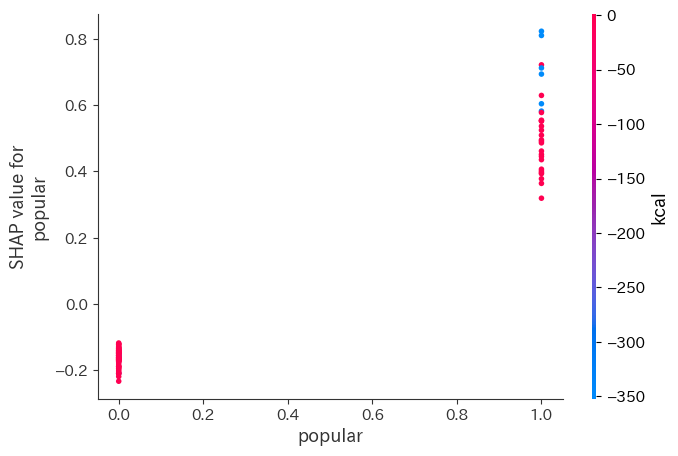

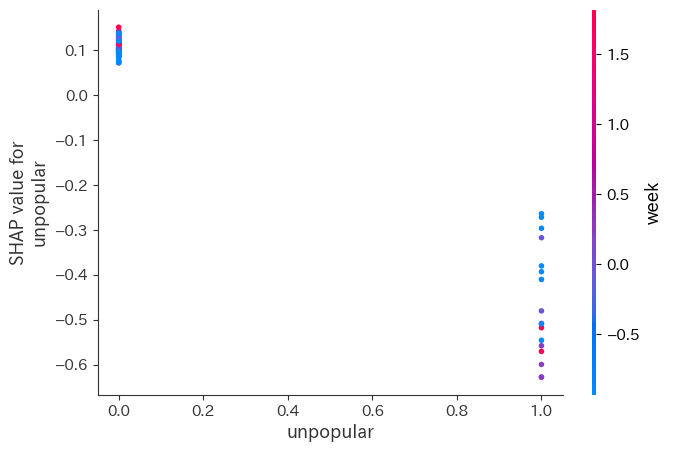

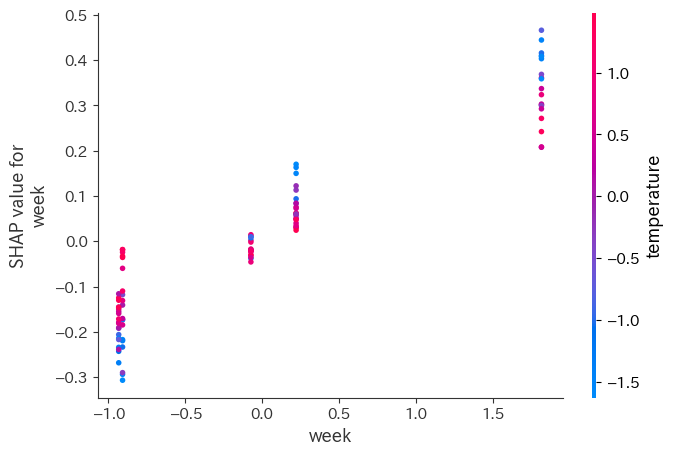

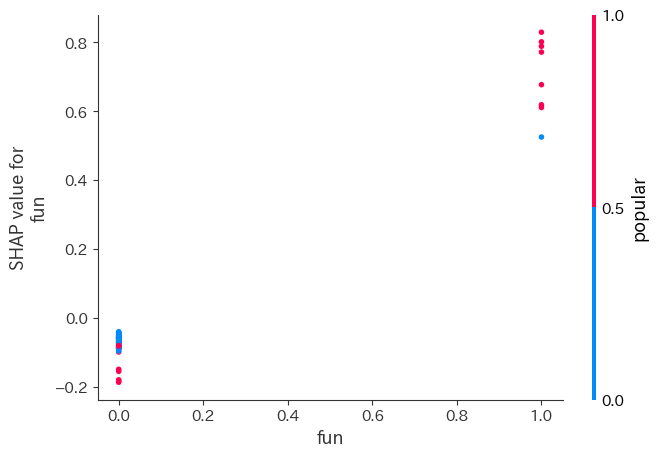

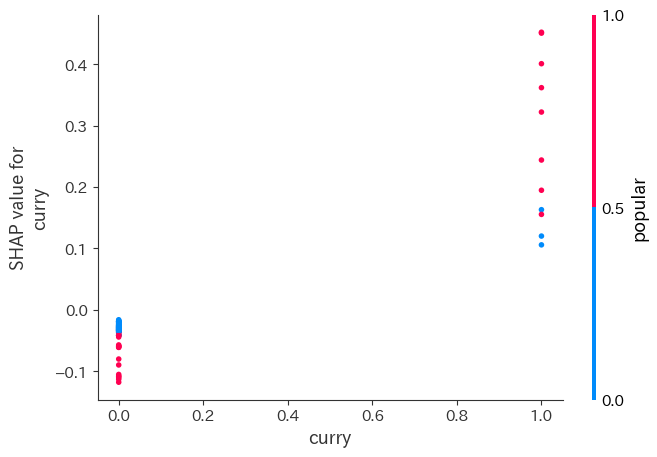

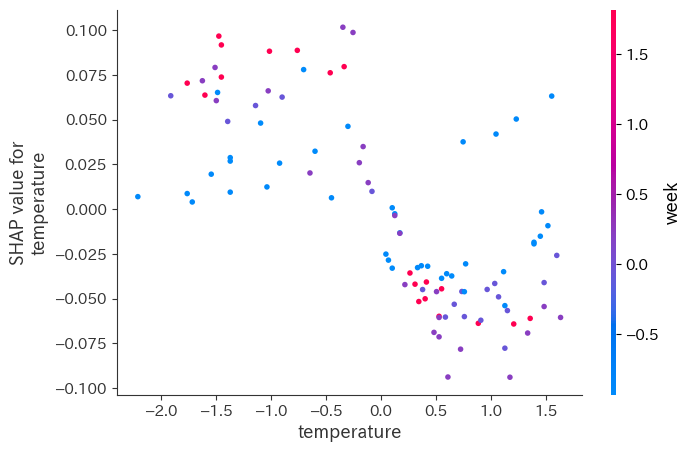

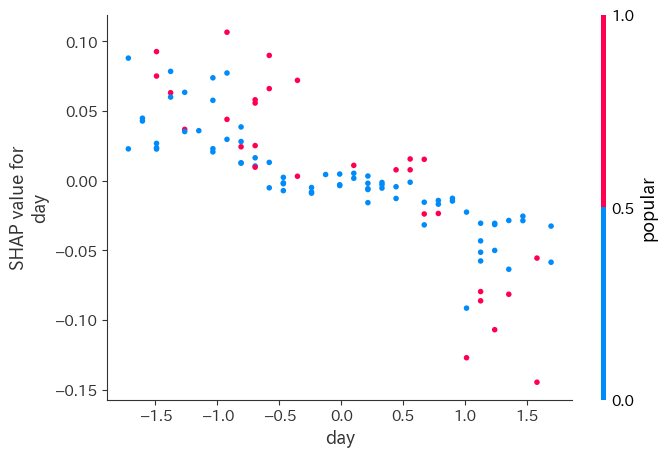

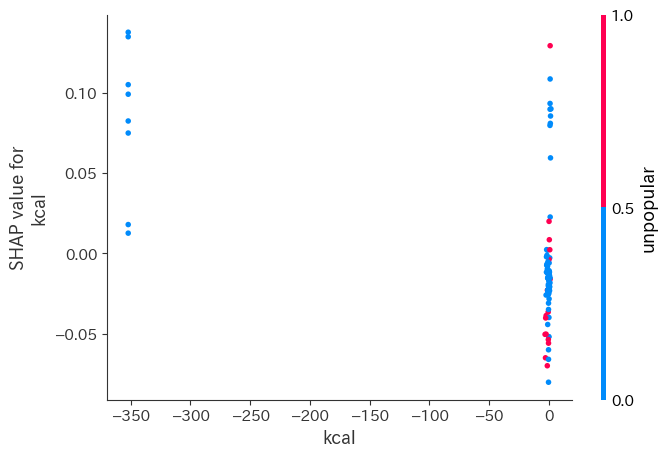

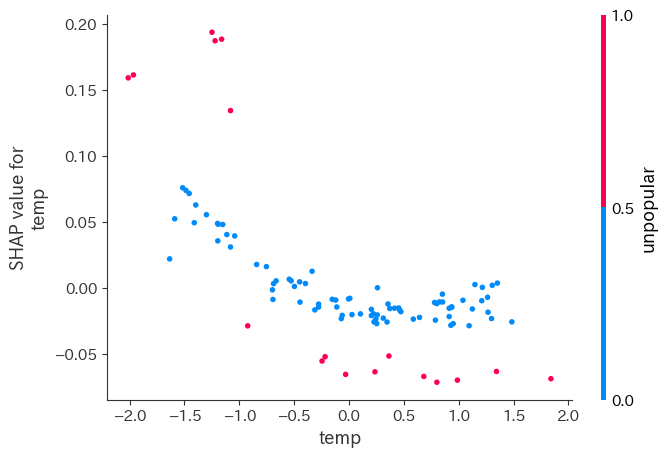

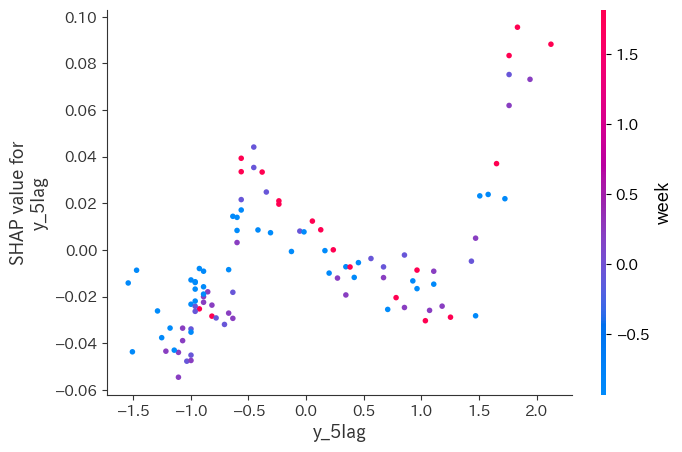

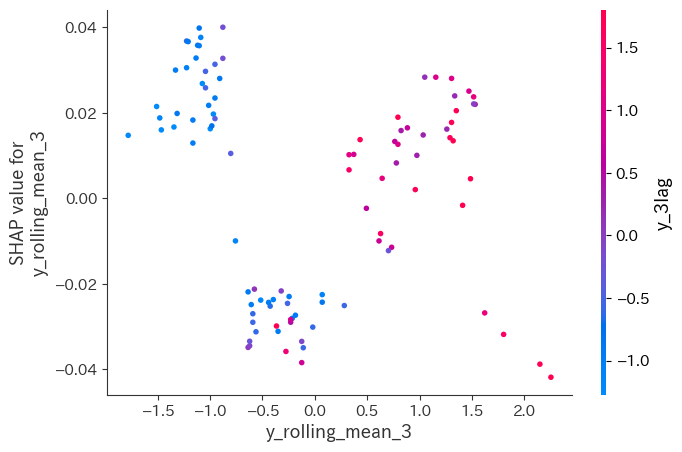

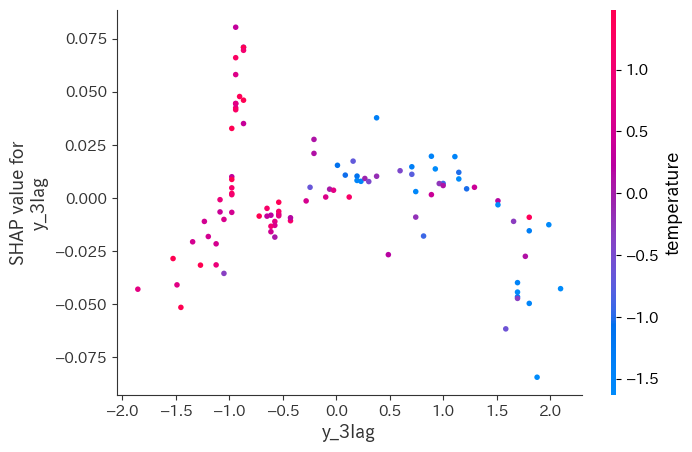

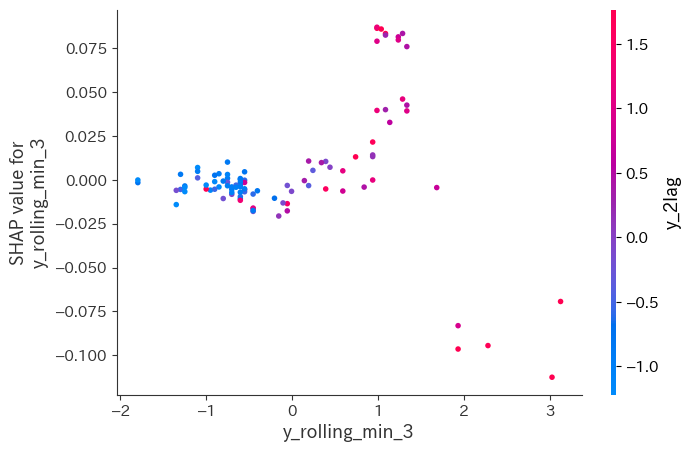

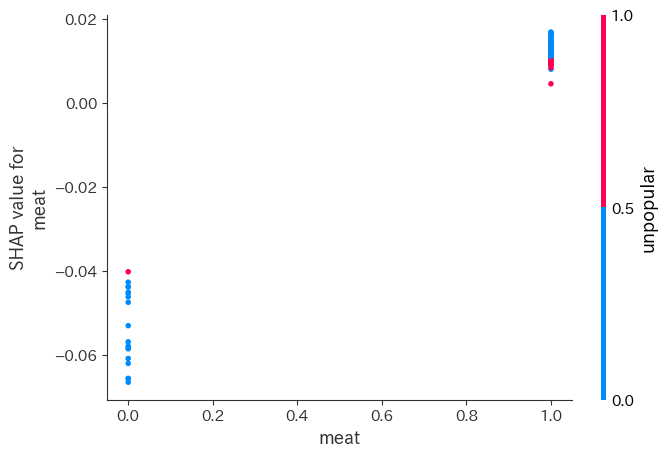

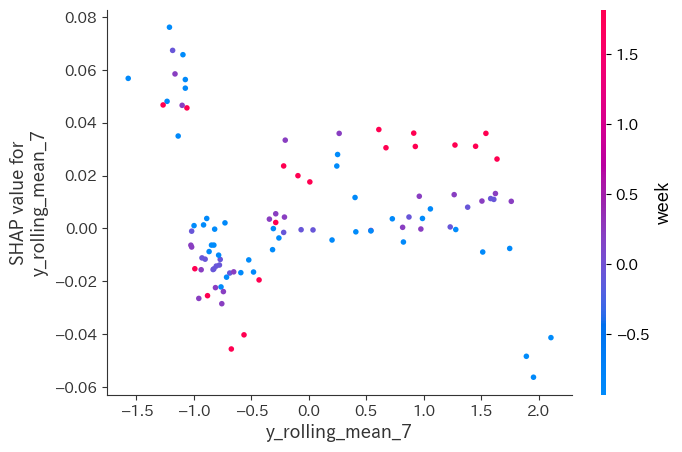

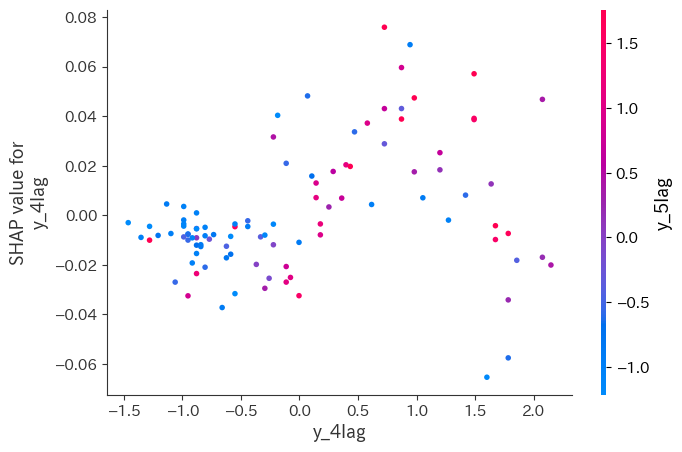

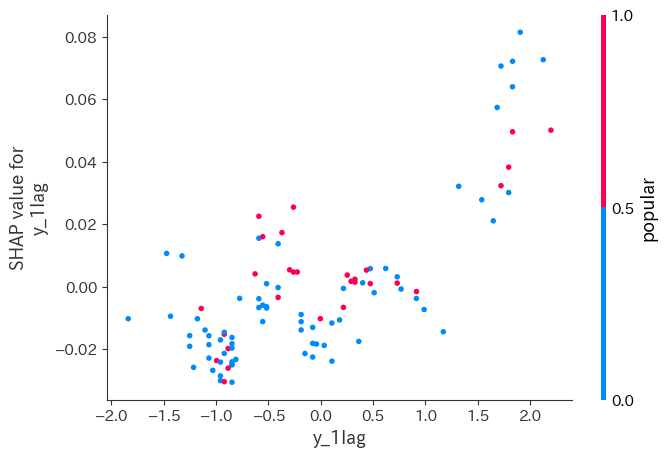

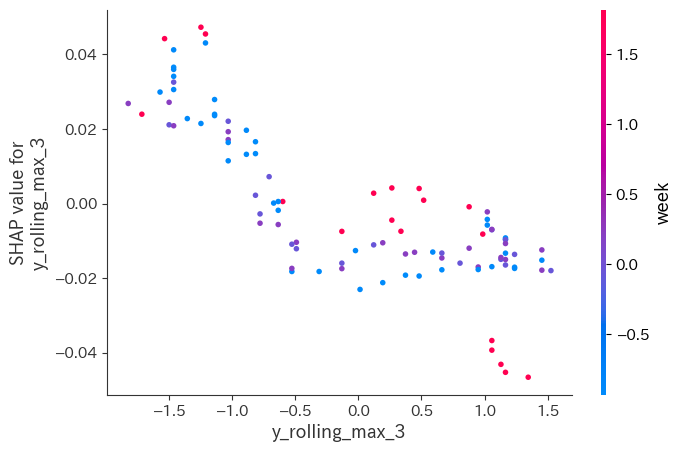

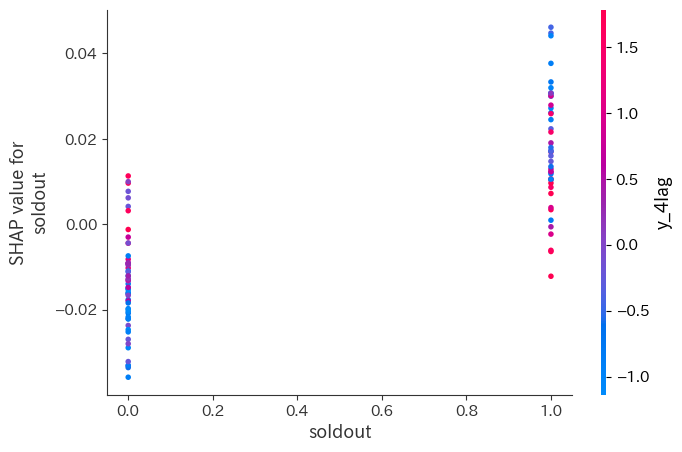

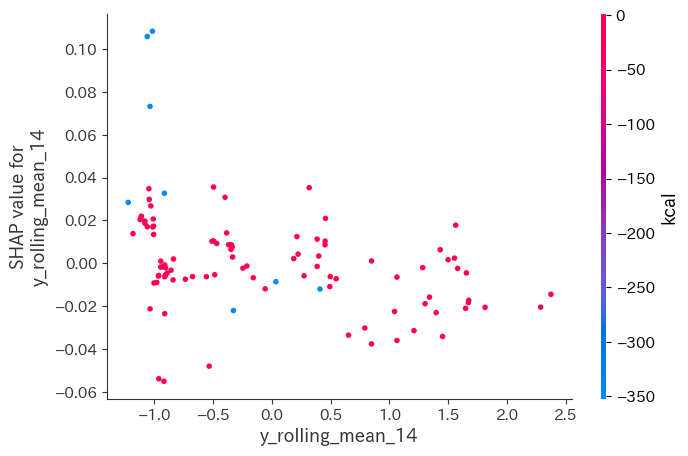

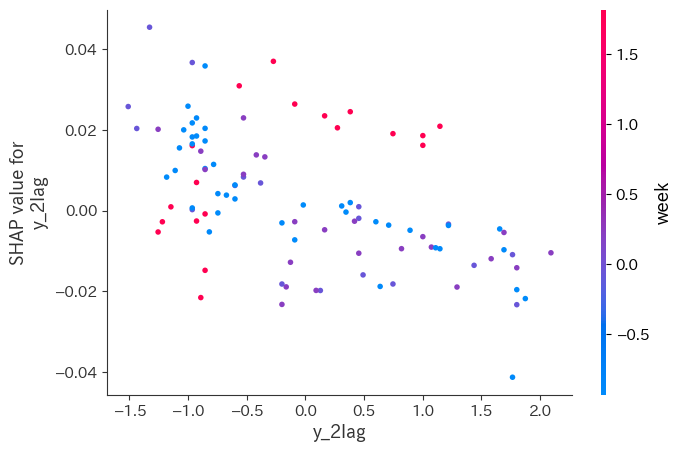

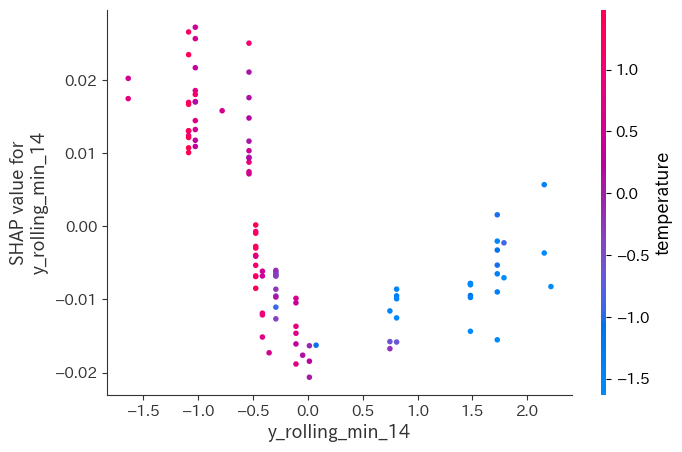

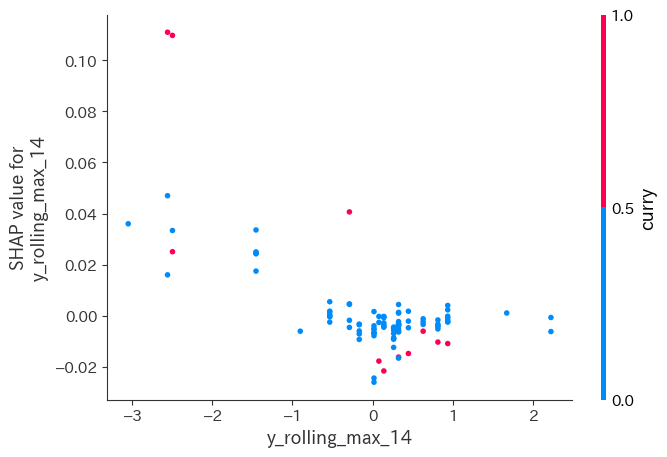

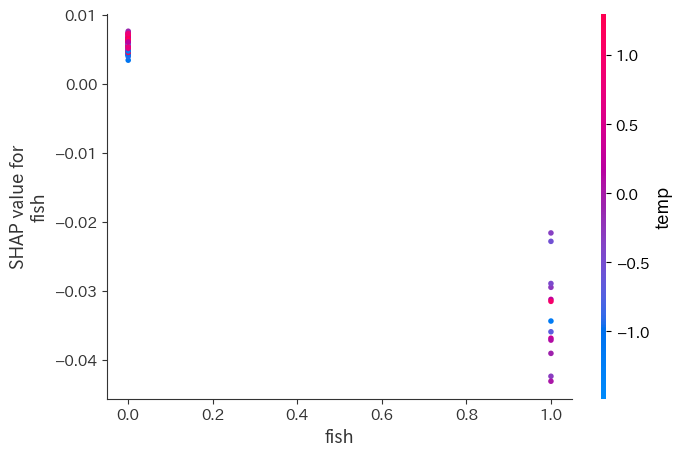

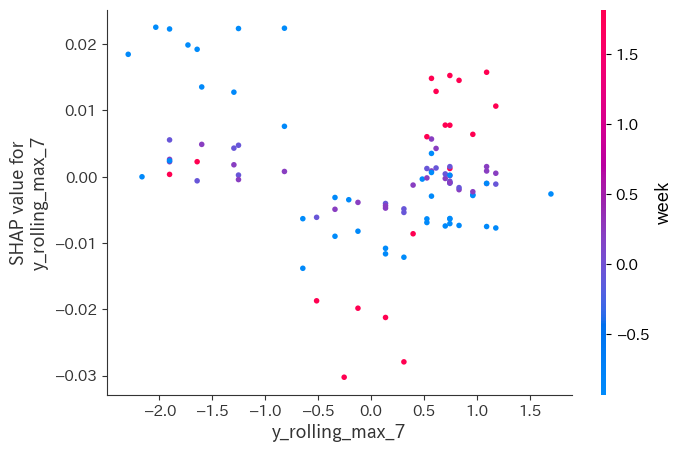

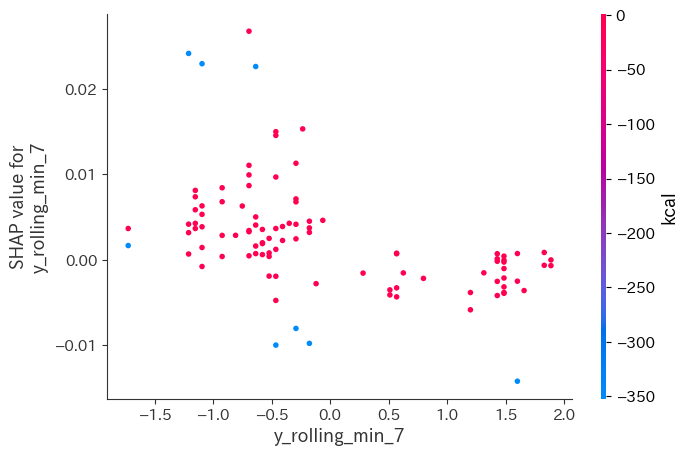

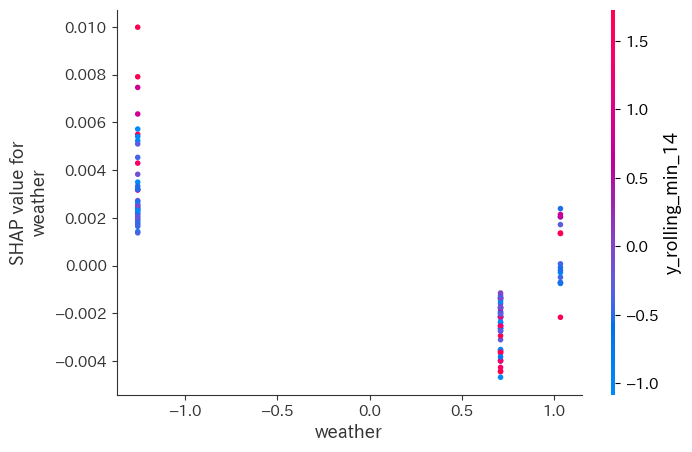

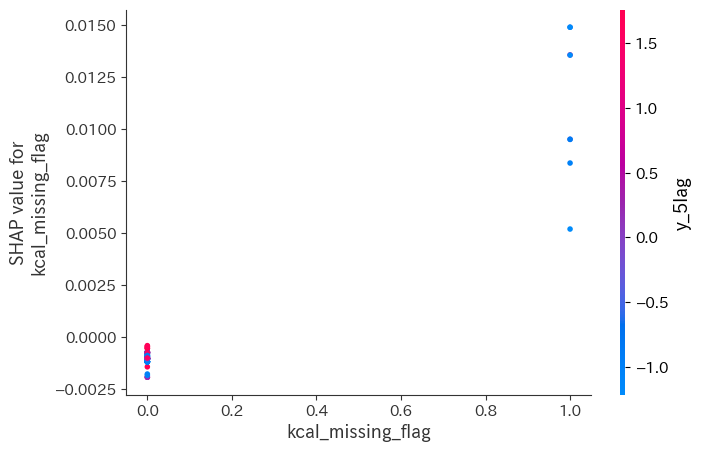

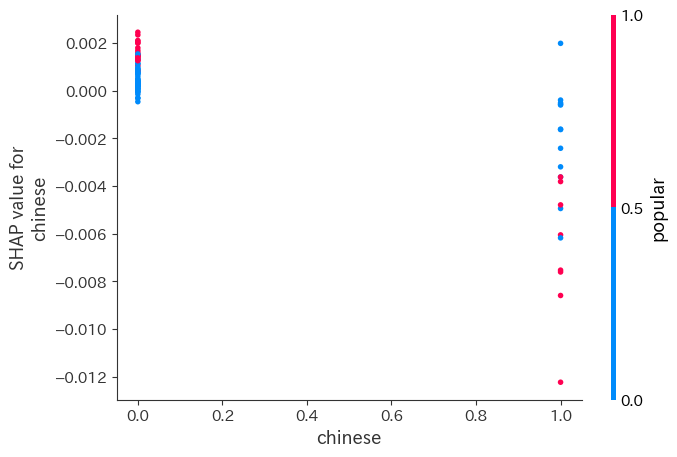

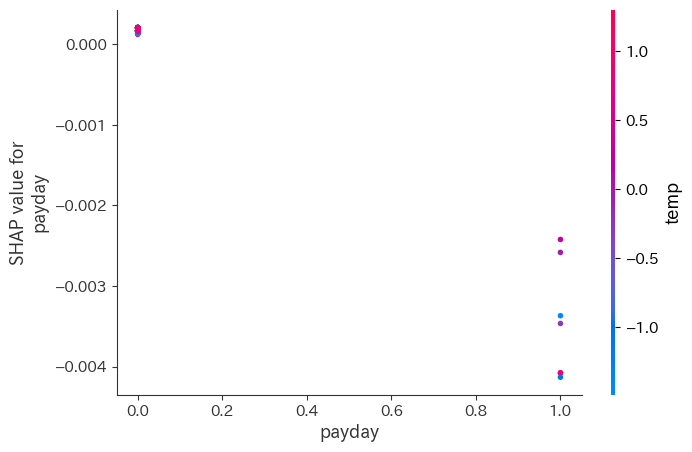

In [16]:
# 特徴量値の変化に応じた変化を描画
for feature in shap_importance['特徴量']:
    shap.dependence_plot(feature, shap_values, shap_sample)

#### 特徴量の作用

In [17]:
# スケーリングされた値を元のスケールに戻す関数
def _inverse_scale(values, feature_name, scaler_params_path):
    scaler_df = pd.read_csv(scaler_params_path, encoding='utf-8-sig')
    row = scaler_df[scaler_df['特徴量名'] == feature_name]

    if row.empty:
        print(f'スケーリング情報が見つかりません: {feature_name}')
        return values
    
    method = row.iloc[0]['手法']

    if method == 'std':
        mean = row.iloc[0]['mean']
        std = row.iloc[0]['std']
        return values * std + mean
    

# 学習時の特徴量のリストを取得する
def _get_model_features_for_pdp(model):
    if isinstance(model, lgb.Booster):
        return model.feature_name()
    else:
        return None


# PDPを描画する関数
def _drew_pdp(df, model_features, feature_name, pred_func, title_suffix='', num_grid_points=50, scaler_param_path=None):
    pdp_isolated = pdp.PDPIsolate(
        model=None if pred_func else model,
        df=df[model_features],
        model_features=model_features,
        feature=feature_name,
        feature_name=feature_name,
        n_classes=0,
        num_grid_points=num_grid_points,
        pred_func=pred_func
    )

    x_vals = pdp_isolated.feature_info.grids
    y_vals = pdp_isolated.results[0].pdp

    # スケーリングを元に戻す
    if scaler_param_path is not None:
        x_vals = _inverse_scale(x_vals, feature_name, scaler_param_path)
    
    plt.figure(figsize=(10, 5))
    plt.plot(x_vals, y_vals, marker='o', linestyle='-')
    plt.xlabel(feature_name)
    plt.ylabel('予測値')
    plt.title(f'特徴量の作用: {feature_name}_{title_suffix}')
    plt.grid(True)
    plt.show()


# 単一モデルに対してPDPを実施する関数
def plot_pdp(model, features, top10_feature_list, model_name='', num_grid_points=50, scaler_param_path=None):
    model_features = _get_model_features_for_pdp(model)

    def pred_func(_, X):
        if isinstance(model, lgb.Booster):
            return model.predict(pd.DataFrame(X, columns=model_features))
        
    for top_feature in top10_feature_list:
        _drew_pdp(
            features,
            model_features,
            top_feature,
            pred_func,
            title_suffix=model_name,
            num_grid_points=num_grid_points,
            scaler_param_path=scaler_param_path
        )

using provided pred_func.


100%|██████████| 2/2 [00:00<00:00, 208.21it/s]


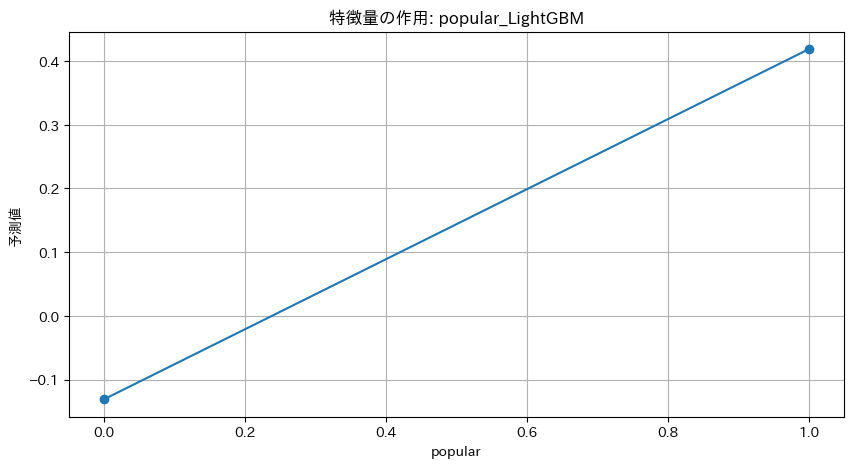

using provided pred_func.


100%|██████████| 2/2 [00:00<00:00, 254.71it/s]


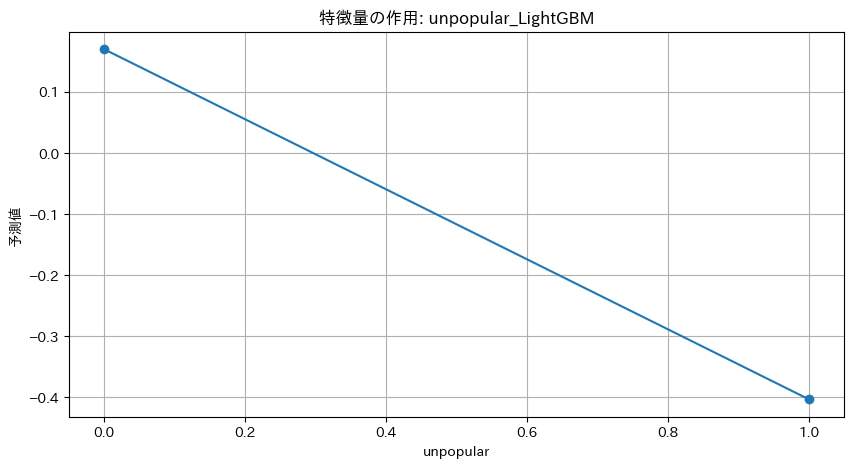

using provided pred_func.


100%|██████████| 12/12 [00:00<00:00, 370.92it/s]


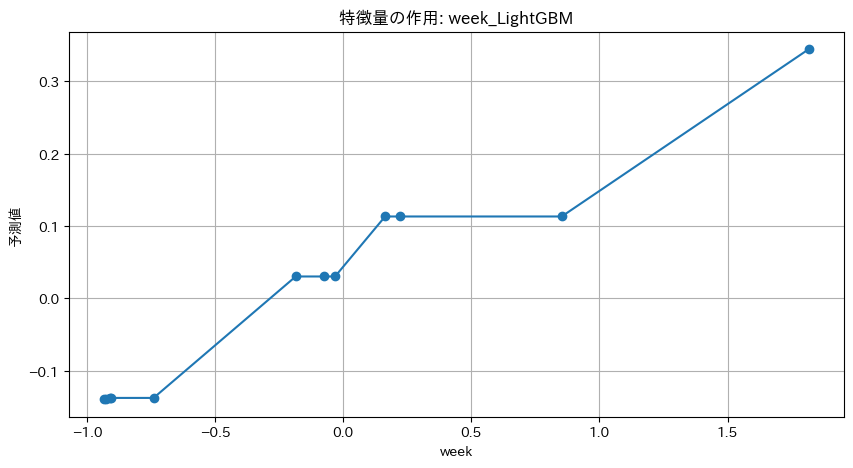

using provided pred_func.


100%|██████████| 2/2 [00:00<00:00, 745.39it/s]


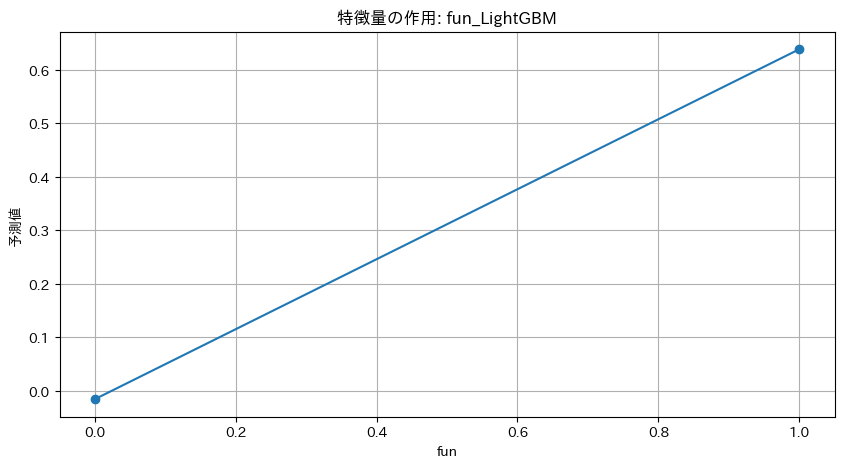

using provided pred_func.


100%|██████████| 2/2 [00:00<00:00, 731.73it/s]


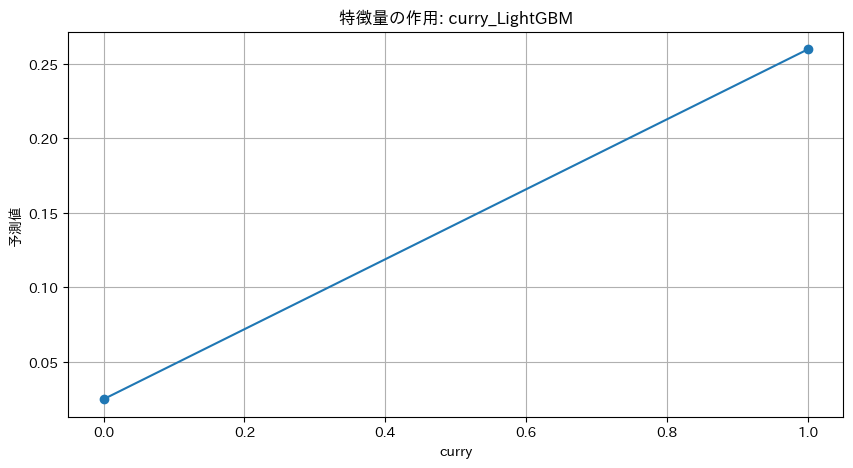

using provided pred_func.


100%|██████████| 143/143 [00:00<00:00, 865.17it/s]


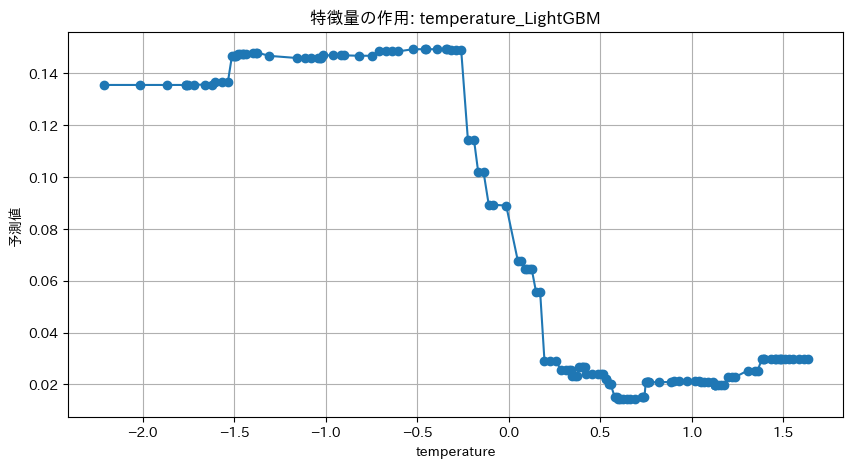

using provided pred_func.


100%|██████████| 74/74 [00:00<00:00, 790.99it/s]


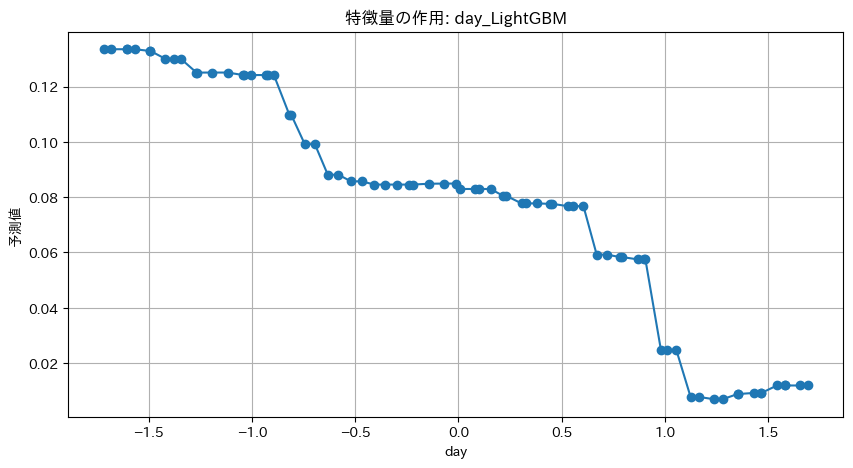

using provided pred_func.


100%|██████████| 103/103 [00:00<00:00, 995.20it/s] 


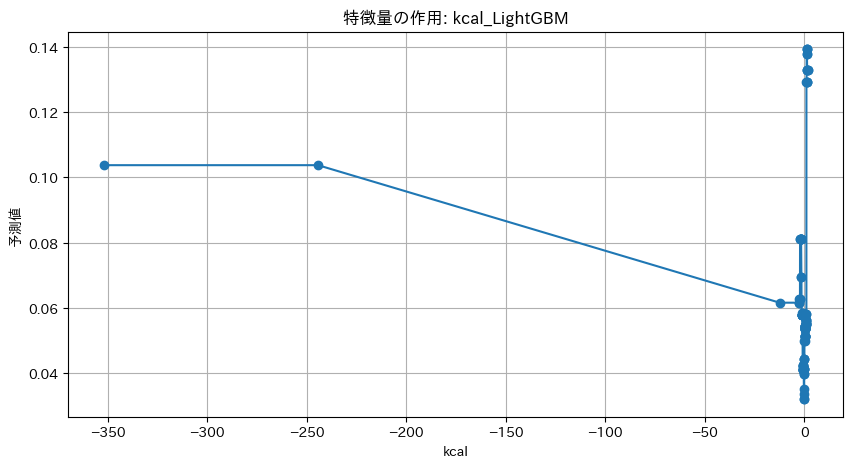

using provided pred_func.


100%|██████████| 149/149 [00:00<00:00, 944.55it/s]


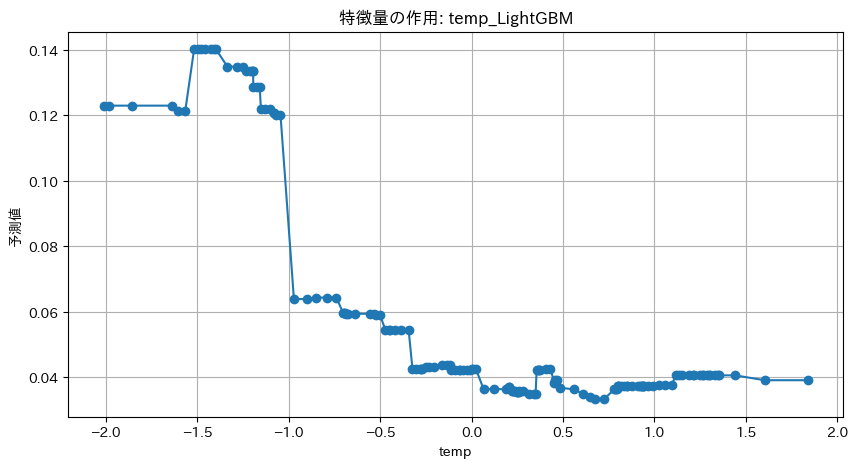

using provided pred_func.


100%|██████████| 114/114 [00:00<00:00, 871.44it/s]


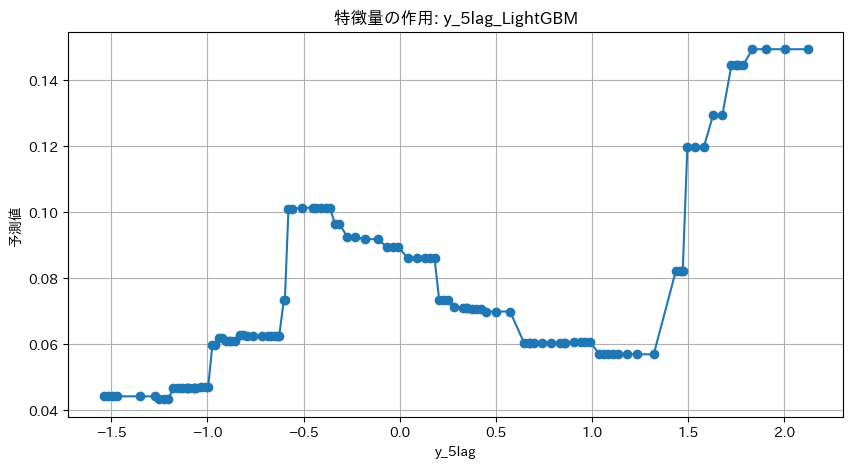

In [18]:
top10_list = shap_importance.iloc[0:10, 0].to_list()
plot_pdp(final_model, shap_sample, top10_list, 'LightGBM', num_grid_points=150, scaler_param_path=None)